In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import librosa
import os
import glob
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm import tqdm
import random

In [6]:
LATENT_DIM = 100
SR = 16000  # Sample rate from MIMII dataset
AUDIO_LENGTH = 10  # seconds (MIMII contains 10s segments)
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 128
BATCH_SIZE = 16
EPOCHS = 300
TIME_DIM = 313  # Setting this explicitly based on your output

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import librosa
import os
import glob
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm import tqdm

# Configuration parameters
LATENT_DIM = 100
SR = 16000  # Sample rate from MIMII dataset
AUDIO_LENGTH = 10  # seconds (MIMII contains 10s segments)
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 128
BATCH_SIZE = 8  # Reduced batch size
EPOCHS = 300
TIME_DIM = 313  # Setting this explicitly based on your output

# Data loading and preprocessing functions
def load_and_preprocess_audio(file_path, is_abnormal=False):
    """Load audio file and convert to mel spectrogram"""
    # Load audio file
    audio, _ = librosa.load(file_path, sr=SR, duration=AUDIO_LENGTH)
    
    # Pad if needed
    if len(audio) < SR * AUDIO_LENGTH:
        audio = np.pad(audio, (0, SR * AUDIO_LENGTH - len(audio)))
    elif len(audio) > SR * AUDIO_LENGTH:
        audio = audio[:SR * AUDIO_LENGTH]
    
    # Create mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio, 
        sr=SR, 
        n_fft=N_FFT, 
        hop_length=HOP_LENGTH, 
        n_mels=N_MELS
    )
    
    # Convert to log scale
    log_mel_spec = librosa.power_to_db(mel_spec)
    
    # Normalize
    log_mel_spec = (log_mel_spec - log_mel_spec.min()) / (log_mel_spec.max() - log_mel_spec.min())
    
    # Add channel dimension
    log_mel_spec = np.expand_dims(log_mel_spec, axis=-1)
    
    # Pad to match expected shape if needed
    if log_mel_spec.shape[1] < TIME_DIM:
        pad_width = ((0, 0), (0, TIME_DIM - log_mel_spec.shape[1]), (0, 0))
        log_mel_spec = np.pad(log_mel_spec, pad_width, mode='constant')
    elif log_mel_spec.shape[1] > TIME_DIM:
        log_mel_spec = log_mel_spec[:, :TIME_DIM, :]
    
    # Add label for condition (0 for normal, 1 for abnormal)
    condition = 1 if is_abnormal else 0
    
    return log_mel_spec, condition

def process_mimii_dataset(base_dir, machine_ids=["00", "02", "04", "06"]):
    """Process MIMII dataset files for a specific machine type and dB level"""
    specs = []
    conditions = []
    
    # Process each machine ID
    for machine_id in machine_ids:
        # Process normal sounds
        normal_dir = os.path.join(base_dir, "id_" + machine_id, "normal")
        if os.path.exists(normal_dir):
            normal_files = glob.glob(os.path.join(normal_dir, "*.wav"))
            
            print(f"Processing {len(normal_files)} normal files for fan id_{machine_id}")
            for file_path in tqdm(normal_files[:50]):  # Limit to 50 files per folder for faster processing
                try:
                    spec, condition = load_and_preprocess_audio(file_path, is_abnormal=False)
                    specs.append(spec)
                    conditions.append(condition)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
        else:
            print(f"Normal directory not found: {normal_dir}")
        
        # Process abnormal sounds
        abnormal_dir = os.path.join(base_dir, "id_" + machine_id, "abnormal")
        if os.path.exists(abnormal_dir):
            abnormal_files = glob.glob(os.path.join(abnormal_dir, "*.wav"))
            
            print(f"Processing {len(abnormal_files)} abnormal files for fan id_{machine_id}")
            for file_path in tqdm(abnormal_files[:50]):  # Limit to 50 files per folder for faster processing
                try:
                    spec, condition = load_and_preprocess_audio(file_path, is_abnormal=True)
                    specs.append(spec)
                    conditions.append(condition)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
        else:
            print(f"Abnormal directory not found: {abnormal_dir}")
    
    # If no files were found, create some dummy data to avoid errors
    if len(specs) == 0:
        print("WARNING: No files were processed. Creating dummy data for debugging.")
        return np.zeros((10, N_MELS, TIME_DIM, 1)), np.zeros(10)
    
    # Convert to numpy arrays
    specs = np.array(specs)
    conditions = np.array(conditions)
    
    print(f"Dataset shape: {specs.shape}, Conditions shape: {conditions.shape}")
    
    return specs, conditions

# Custom Resizing Layer to ensure exact output dimensions
class ExactOutputSize(layers.Layer):
    def __init__(self, target_height, target_width, **kwargs):
        super(ExactOutputSize, self).__init__(**kwargs)
        self.target_height = target_height
        self.target_width = target_width
        
    def build(self, input_shape):
        super(ExactOutputSize, self).build(input_shape)
        
    def call(self, inputs):
        return tf.image.resize(inputs, [self.target_height, self.target_width])
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.target_height, self.target_width, input_shape[3])
        
    def get_config(self):
        config = super(ExactOutputSize, self).get_config()
        config.update({
            'target_height': self.target_height,
            'target_width': self.target_width
        })
        return config

# Generator network
def build_generator(latent_dim):
    """Build generator network with conditional input"""
    # Input for latent space
    noise = layers.Input(shape=(latent_dim,), name="noise_input")
    
    # Input for conditions (normal/abnormal)
    condition = layers.Input(shape=(1,), name="condition_input")
    
    # Embed the condition
    condition_embedding = layers.Embedding(2, 50)(condition)
    condition_embedding = layers.Flatten()(condition_embedding)
    
    # Concatenate noise and condition
    combined_input = layers.Concatenate()([noise, condition_embedding])
    
    # Dense layers
    x = layers.Dense(256)(combined_input)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    
    # Calculate dimensions for reshaping
    target_height = N_MELS // 8  # 16
    target_width = TIME_DIM // 16  # 19 for TIME_DIM=313
    
    x = layers.Dense(target_height * target_width * 64)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Reshape((target_height, target_width, 64))(x)
    
    # Transposed convolution layers to upsample
    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    
    x = layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    
    x = layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    
    x = layers.Conv2DTranspose(8, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    
    # Ensure exact output dimensions match the input data
    x = ExactOutputSize(N_MELS, TIME_DIM)(x)
    
    # Output layer
    output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Model
    model = models.Model([noise, condition], output, name="generator")
    
    return model

# Discriminator network
def build_discriminator():
    """Build discriminator network with conditional input"""
    # Input for spectrogram with explicit shape
    input_spec = layers.Input(shape=(N_MELS, TIME_DIM, 1), name="spec_input")
    
    # Input for conditions (normal/abnormal)
    condition = layers.Input(shape=(1,), name="condition_input")
    
    # Embedding layer for condition - reshape to match input spec dimensions
    embedding_dim = N_MELS * TIME_DIM
    condition_embedding = layers.Embedding(2, embedding_dim)(condition)
    condition_embedding = layers.Reshape((N_MELS, TIME_DIM, 1))(condition_embedding)
    
    # Concatenate inputs along the channel dimension
    combined_input = layers.Concatenate(axis=-1)([input_spec, condition_embedding])
    
    # Convolutional layers with explicit padding='same' to maintain dimensions
    x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same')(combined_input)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    
    # Output layer
    output = layers.Dense(1, activation='sigmoid')(x)
    
    # Model
    model = models.Model([input_spec, condition], output, name="discriminator")
    
    return model

# GAN model
def build_gan(generator, discriminator):
    """Build combined GAN model"""
    # Freeze discriminator during generator training
    discriminator.trainable = False
    
    # GAN input
    noise = layers.Input(shape=(LATENT_DIM,), name="gan_noise_input")
    condition = layers.Input(shape=(1,), name="gan_condition_input")
    
    # Generator output
    generated_spec = generator([noise, condition])
    
    # Discriminator output
    validity = discriminator([generated_spec, condition])
    
    # Combined model
    model = models.Model([noise, condition], validity, name="gan")
    
    return model

# Function to convert spectrogram back to audio
def spectrogram_to_audio(spectrogram):
    """Convert a generated spectrogram back to audio"""
    # Remove extra dimensions and denormalize
    spectrogram = spectrogram.squeeze()
    
    # Convert from dB back to power
    S = librosa.db_to_power(spectrogram * 80 - 80)  # Rough denormalization
    
    # Mel spectrogram to audio using Griffin-Lim algorithm
    y = librosa.feature.inverse.mel_to_audio(
        S, 
        sr=SR, 
        n_fft=N_FFT, 
        hop_length=HOP_LENGTH,
        power=2.0
    )
    
    return y

# Training functions
def train_gan(generator, discriminator, gan, specs, conditions, epochs, batch_size, save_interval=50):
    """Train the GAN model"""
    
    # Create folder for samples
    os.makedirs("generated_samples", exist_ok=True)
    
    # Get the number of total examples
    half_batch = batch_size // 2
    
    # Arrays to store loss values
    d_losses = []
    g_losses = []
    
    # Training loop
    for epoch in range(epochs):
        # -----------------
        # Train Discriminator
        # -----------------
        
        # Select random batch of real spectrograms
        idx = np.random.randint(0, specs.shape[0], half_batch)
        real_specs = specs[idx]
        real_conditions = conditions[idx].reshape(-1, 1)
        
        # Generate batch of fake spectrograms
        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        fake_conditions = np.random.randint(0, 2, (half_batch, 1))
        
        # Generate fake spectrograms
        fake_specs = generator.predict([noise, fake_conditions])
        
        # Train discriminator
        d_loss_real = discriminator.train_on_batch(
            [real_specs, real_conditions], 
            np.ones((half_batch, 1))
        )
        d_loss_fake = discriminator.train_on_batch(
            [fake_specs, fake_conditions], 
            np.zeros((half_batch, 1))
        )
        
        # Calculate discriminator loss (taking mean of real and fake losses)
        if isinstance(d_loss_real, list):
            d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        else:
            d_loss = 0.5 * (d_loss_real + d_loss_fake)
        
        # -----------------
        # Train Generator
        # -----------------
        
        # Generate new batch of noise and conditions
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        random_conditions = np.random.randint(0, 2, (batch_size, 1))
        
        # Train generator (via the GAN model, where discriminator weights are frozen)
        g_loss = gan.train_on_batch([noise, random_conditions], np.ones((batch_size, 1)))
        
        # Store losses
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
        # Print progress - use string formatting carefully to avoid numpy format error
        if isinstance(d_loss, np.ndarray):
            d_loss_val = float(d_loss)
        else:
            d_loss_val = d_loss
            
        if isinstance(g_loss, np.ndarray):
            g_loss_val = float(g_loss)
        else:
            g_loss_val = g_loss
            
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss_val:.4f} | G Loss: {g_loss_val:.4f}")
        
        # Save generated samples
        if (epoch + 1) % save_interval == 0:
            save_generated_samples(generator, epoch + 1)
    
    # Save final model
    generator.save("mimii_generator.h5")
    discriminator.save("mimii_discriminator.h5")
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_curves.png')
    
    return d_losses, g_losses

def save_generated_samples(generator, epoch):
    """Save generated spectrograms and audio samples"""
    # Generate noise and conditions
    noise = np.random.normal(0, 1, (2, LATENT_DIM))
    conditions = np.array([[0], [1]])  # Normal and abnormal
    
    # Generate spectrograms
    gen_specs = generator.predict([noise, conditions])
    
    # Save spectrograms as images
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(gen_specs[0, :, :, 0])
    plt.title("Normal Machine Sound")
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(gen_specs[1, :, :, 0])
    plt.title("Abnormal Machine Sound")
    plt.colorbar()
    
    plt.tight_layout()
    plt.savefig(f"generated_samples/spectrograms_epoch_{epoch}.png")
    plt.close()
    
    # Convert spectrograms to audio and save
    for i, condition in enumerate(["normal", "abnormal"]):
        audio = spectrogram_to_audio(gen_specs[i])
        sf.write(f"generated_samples/{condition}_epoch_{epoch}.wav", audio, SR)

In [11]:
def main():
    # Set path to your dataset location
    base_dir = r"C:\Users\julia\DS4440\machine-noise-generator\data\fan"
    
    # Process data
    specs, conditions = process_mimii_dataset(base_dir)
    
    # Build models with explicit shapes
    generator = build_generator(LATENT_DIM)
    discriminator = build_discriminator()
    
    # Print model summaries
    print("\nGenerator Summary:")
    generator.summary()
    print("\nDiscriminator Summary:")
    discriminator.summary()
    
    # Test the generator to verify output shape
    noise = np.random.normal(0, 1, (1, LATENT_DIM))
    condition = np.array([[0]])  # Normal condition
    test_output = generator.predict([noise, condition])
    print(f"Generator test output shape: {test_output.shape}")
    
    # Test the discriminator to verify it accepts the generator's output
    disc_output = discriminator.predict([test_output, condition])
    print(f"Discriminator test output shape with generator output: {disc_output.shape}")
    
    # Build GAN
    gan = build_gan(generator, discriminator)
    
    # Compile models with lower learning rates
    discriminator.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    gan.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5),
        loss='binary_crossentropy'
    )
    
    # Start with short training
    short_epochs = 5
    try:
        print("Starting short training run...")
        train_gan(generator, discriminator, gan, specs, conditions, short_epochs, BATCH_SIZE)
        
        print("Short training successful! Now starting full training...")
        # If short training works, continue with full training
        full_epochs = 300
        train_gan(generator, discriminator, gan, specs, conditions, full_epochs, BATCH_SIZE)
        
    except Exception as e:
        print(f"Error during training: {str(e)}")
        # Print detailed error info
        import traceback
        traceback.print_exc()

Processing 1011 normal files for fan id_00


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.95it/s]


Processing 407 abnormal files for fan id_00


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 51.95it/s]


Processing 1016 normal files for fan id_02


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 57.32it/s]


Processing 359 abnormal files for fan id_02


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.89it/s]


Processing 1033 normal files for fan id_04


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.45it/s]


Processing 348 abnormal files for fan id_04


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.37it/s]


Processing 1015 normal files for fan id_06


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.60it/s]


Processing 361 abnormal files for fan id_06


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.89it/s]


Dataset shape: (400, 128, 313, 1), Conditions shape: (400,)

Generator Summary:


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ condition_input (InputLayer)  │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, 1, 50)             │             100 │ condition_input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ noise_input (InputLayer)      │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 50)                │               0 │ embedding_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 150)               │               0 │ noise_input[0][0],         │
│                               │                           │                 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 256)               │          38,656 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_12 (LeakyReLU)    │ (None, 256)               │               0 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 512)               │         131,584 │ leaky_re_lu_12[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_13 (LeakyReLU)    │ (None, 512)               │               0 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 19456)             │       9,980,928 │ leaky_re_lu_13[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_14 (LeakyReLU)    │ (None, 19456)             │               0 │ dense_7[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_2 (Reshape)           │ (None, 16, 19, 64)        │               0 │ leaky_re_lu_14[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_4            │ (None, 32, 38, 64)        │          65,600 │ reshape_2[0][0]            │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_15 (LeakyReLU)    │ (None, 32, 38, 64)        │               0 │ conv2d_transpose_4[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_5            │ (None, 64, 76, 32)        │          32,800 │ leaky_re_lu_15[0][0]       │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_16 (LeakyReLU)    │ (None, 64, 76, 32)        │               

 Total params: 10,260,005 (39.14 MB)

 Trainable params: 10,260,005 (39.14 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator Summary:


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ condition_input (InputLayer)  │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_3 (Embedding)       │ (None, 1, 40064)          │          80,128 │ condition_input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spec_input (InputLayer)       │ (None, 128, 313, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_3 (Reshape)           │ (None, 128, 313, 1)       │               0 │ embedding_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 128, 313, 2)       │               0 │ spec_input[0][0],          │
│                               │                           │                 │ reshape_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 64, 157, 32)       │             608 │ concatenate_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_19 (LeakyReLU)    │ (None, 64, 157, 32)       │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 64, 157, 32)       │               0 │ leaky_re_lu_19[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 79, 64)        │          18,496 │ dropout_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_20 (LeakyReLU)    │ (None, 32, 79, 64)        │               0 │ conv2d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_5 (Dropout)           │ (None, 32, 79, 64)        │               0 │ leaky_re_lu_20[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 16, 40, 128)       │          73,856 │ dropout_5[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_21 (LeakyReLU)    │ (None, 16, 40, 128)       │               0 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 16, 40, 128)       │               0 │ leaky_re_lu_21[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 8, 20, 256)        │         295,168 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_22 (LeakyReLU)    │ (None, 8, 20, 256)        │               0 │ conv2d_9[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 8, 20, 256)        │               

 Total params: 21,440,801 (81.79 MB)

 Trainable params: 21,440,801 (81.79 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Generator test output shape: (1, 128, 313, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Discriminator test output shape with generator output: (1, 1)
Starting short training run...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Epoch 1/5 | D Loss: 0.6856 | G Loss: 0.6906
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Epoch 2/5 | D Loss: 0.6900 | G Loss: 0.6902
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Epoch 3/5 | D Loss: 0.6933 | G Loss: 0.6932
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Epoch 4/5 | D Loss: 0.6937 | G Loss: 0.6908
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 5/5 | D Loss: 0.6961 | G Loss: 0.6873
Short training successful! Now starting full training...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Epoch 1/300 | D Loss: 0.6979 | G Loss: 0.6881
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Epoch 2/300 | D Loss: 0.6969 | G Loss: 0.6886
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Epoch 3/300 | D Loss: 0.6983 | G Loss: 0.6887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Epoch 4/300 | D Loss: 0.6987 | G Loss: 0.6880
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Epoch 5/300 | D Loss: 0.6983 | G Loss: 0.6877
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Epoch 6/300 | D Loss: 0.6976 | G Loss: 0.6885
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Epoch 7/300 | D Loss: 0.6971 | G Loss: 0.6889
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Epoch 8/300 | D Loss: 0.6972 | G Loss: 0.6871
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Epoch 9/300 | D Loss: 0.6965 | G Loss: 0.6879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Epoch 10/300 | D Loss: 0.6965 | G Loss: 0.6874
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Epoch 11/300 | D 

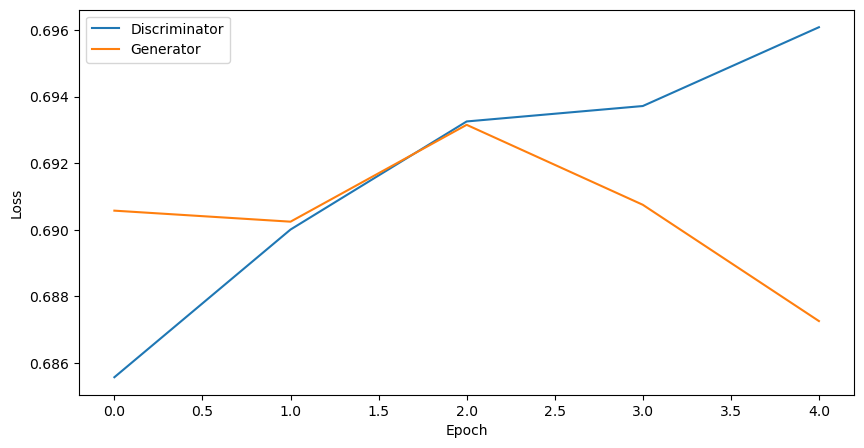

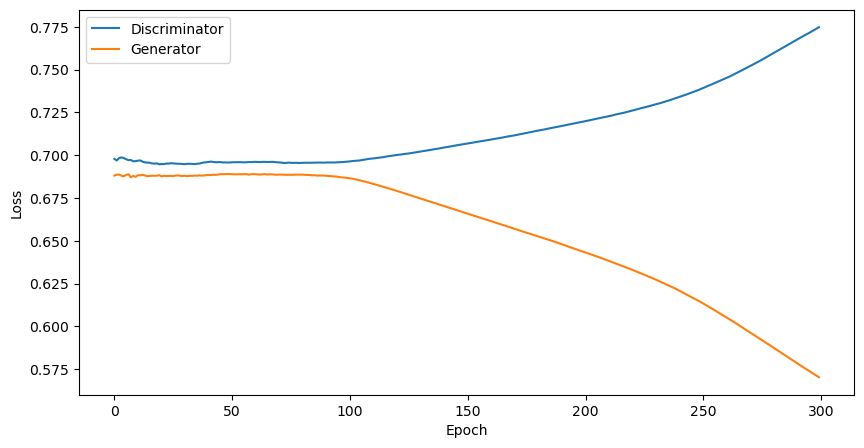

In [12]:
if __name__ == "__main__":
    main()